# PROJET HADOOP : RETARD ET ANNULATION DANS LES AEROPORTS AMERICAINS

### IMPORT ET RECUPERATION DE DONNEES

In [43]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import findspark
findspark.init()

In [44]:
import pyspark
from pyspark.sql import SparkSession
#import the maximum - max function
from pyspark.sql.functions import max
from pyspark.sql.functions import col
from pyspark.sql import Row
from pyspark.sql.functions import sum as _sum
from pyspark.sql.functions import mean as _mean
from pyspark.sql.functions import min as _min
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

In [45]:

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [15]:
#spark.read.option('header', 'true').csv("hdfs://localhost:9000/esgi/data/projets/planes/airlines4.csv", inferSchema=True).write.csv("hdfs://localhost:9000/PATH_HDFS")

In [46]:
path_repositories = "hdfs://localhost:9000/esgi/data/projets/planes/airlines4.csv"
# sdf = spark.read.format('csv').options(delimiter=",", header=True).load(path_repositories)
df = spark.read.option('header', 'true').csv(path_repositories, inferSchema=True)
# df = df.select("Airport.Code")


# df = sdf.select("*").toPandas()
# #df.groupBy("Airport.Code").count().show()

# df


## TRAITEMENT DE LA DONNEES

### Affichage colonne

In [47]:
df.printSchema()

root
 |-- airport_code: string (nullable = true)
 |-- airport_name: string (nullable = true)
 |-- airport_name_full: string (nullable = true)
 |-- time_label: string (nullable = true)
 |-- time_month: integer (nullable = true)
 |-- time_month_name: string (nullable = true)
 |-- time_year: integer (nullable = true)
 |-- statistics_of_delays_carrier: integer (nullable = true)
 |-- statistics_of_delays_late_aircraft: integer (nullable = true)
 |-- statistics_of_delays_national_aviation_system: integer (nullable = true)
 |-- statistics_of_delays_security: integer (nullable = true)
 |-- statistics_of_delays_weather: integer (nullable = true)
 |-- statistics_carriers_total: integer (nullable = true)
 |-- statistics_flights_cancelled: integer (nullable = true)
 |-- statistics_flights_delayed: integer (nullable = true)
 |-- statistics_flights_diverted: integer (nullable = true)
 |-- statistics_flights_on_time: integer (nullable = true)
 |-- statistics_flights_total: integer (nullable = true)
 

### Suppression de colonne

In [48]:
df= df.drop(*('_c18', '_c19'))
df.printSchema()

root
 |-- airport_code: string (nullable = true)
 |-- airport_name: string (nullable = true)
 |-- airport_name_full: string (nullable = true)
 |-- time_label: string (nullable = true)
 |-- time_month: integer (nullable = true)
 |-- time_month_name: string (nullable = true)
 |-- time_year: integer (nullable = true)
 |-- statistics_of_delays_carrier: integer (nullable = true)
 |-- statistics_of_delays_late_aircraft: integer (nullable = true)
 |-- statistics_of_delays_national_aviation_system: integer (nullable = true)
 |-- statistics_of_delays_security: integer (nullable = true)
 |-- statistics_of_delays_weather: integer (nullable = true)
 |-- statistics_carriers_total: integer (nullable = true)
 |-- statistics_flights_cancelled: integer (nullable = true)
 |-- statistics_flights_delayed: integer (nullable = true)
 |-- statistics_flights_diverted: integer (nullable = true)
 |-- statistics_flights_on_time: integer (nullable = true)
 |-- statistics_flights_total: integer (nullable = true)



### Renommer les noms de colonnes

In [49]:
df = df.withColumnRenamed("statistics_flights_delayed", "flights_delayed").withColumnRenamed("statistics_flights_cancelled", "flights_cancelled")
df.select("*").toPandas()

,airport_code,airport_name,airport_name_full,time_label,time_month,time_month_name,time_year,statistics_of_delays_carrier,statistics_of_delays_late_aircraft,statistics_of_delays_national_aviation_system,statistics_of_delays_security,statistics_of_delays_weather,statistics_carriers_total,flights_cancelled,flights_delayed,statistics_flights_diverted,statistics_flights_on_time,statistics_flights_total
0,ATL,Atlanta,GA: Hartsfield-Jackson Atlanta International,01-juin-03,6,June,2003,1009,1275,3217,17,328,11,216,5843,27,23974,30060
1,BOS,Boston,MA: Logan International,01-juin-03,6,June,2003,374,495,685,3,66,14,138,1623,3,7875,9639
2,BWI,Baltimore,MD: Baltimore/Washington International Thurgo...,01-juin-03,6,June,2003,296,477,389,8,78,11,29,1245,15,6998,8287
3,CLT,Charlotte,NC: Charlotte Douglas International,01-juin-03,6,June,2003,300,472,735,2,54,11,73,1562,14,7021,8670
4,DCA,Washington,DC: Ronald Reagan Washington National,01-juin-03,6,June,2003,283,268,487,4,58,13,74,1100,18,5321,6513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4403,SAN,San Diego,CA: San Diego International,01-janv.-16,1,January,2016,280,397,171,2,20,11,97,871,18,5030,6016
4404,SEA,Seattle,WA: Seattle/Tacoma International,01-janv.-16,1,January,2016,357,513,351,2,50,10,104,1274,31,8330,9739
4405,SFO,San Francisco,CA: San Francisco International,01-janv.-16,1,January,2016,560,947,2194,2,119,10,449,3825,20,8912,13206
4406,SLC,Salt Lake City,UT: Salt Lake City International,01-janv.-16,1,January,2016,338,540,253,3,38,8,84,1175,14,7426,8699


In [55]:
a = df.filter((df.airport_code == "SEA") & (df.time_year == 2015))
a.groupby("airport_code").agg(_sum("statistics_of_delays_carrier")).toPandas()

,airport_code,sum(statistics_of_delays_carrier)
0,SEA,5619


## Statistique et affichage de donnéees

###  Les aéroports existant et leurs codes

In [20]:
df.select("airport_code","airport_name").distinct().toPandas()

,airport_code,airport_name
0,MIA,Miami
1,MCO,Orlando
2,DCA,Washington
3,MDW,Chicago
4,IAD,Washington
5,PHX,Phoenix
6,IAH,Houston
7,ORD,Chicago
8,BWI,Baltimore
9,TPA,Tampa


### nombre de retard par années

In [21]:
df.groupBy("time_year").agg(_sum("flights_delayed").alias("sum_flights_delayed")).sort("time_year", ascending=True).toPandas()

,time_year,sum_flights_delayed
0,2003,411570
1,2004,880677
2,2005,925578
3,2006,1024612
4,2007,1129439
5,2008,965136
6,2009,787472
7,2010,732445
8,2011,715560
9,2012,658326


In [60]:
c= df.filter(df.time_year == 2006).filter(df.airport_code == "SAN")
c.groupBy("time_month").agg(_sum("flights_delayed").alias("sum_flights_delayed")).sort("time_month", ascending=True).toPandas()

,time_month,sum_flights_delayed
0,1,1251
1,2,1740
2,3,1897
3,4,1667
4,5,1343
5,6,1656
6,7,1790
7,8,1633
8,9,1391
9,10,1698


### Evolution du nombre de retard selon  un  aéroport

Quel aéroport voulez-vous voir?
NoneDenver


<AxesSubplot:xlabel='time_year'>

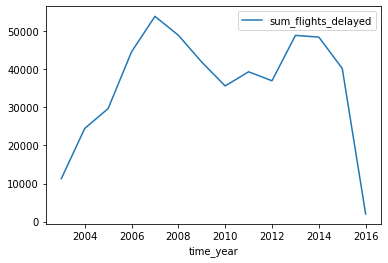

In [56]:
b= input(print("Quel aéroport voulez-vous voir?"))
b= b.capitalize()
c= df.filter(df.airport_name == b)
a = c.groupBy("time_year").agg(_sum("flights_delayed").alias("sum_flights_delayed")).sort("time_year", ascending=True).toPandas()

a.plot.line(x='time_year', y='sum_flights_delayed') 

### Nombre de vol annulés et retardés par aéroport

In [23]:
df.select("airport_name", "flights_delayed", "flights_cancelled").toPandas()

,airport_name,flights_delayed,flights_cancelled
0,Atlanta,5843,216
1,Boston,1623,138
2,Baltimore,1245,29
3,Charlotte,1562,73
4,Washington,1100,74
...,...,...,...
4403,San Diego,871,97
4404,Seattle,1274,104
4405,San Francisco,3825,449
4406,Salt Lake City,1175,84


### Les aéroports classés par plus grand nombre de retards

In [24]:
df.groupBy("airport_code","airport_name")\
.agg(_sum("flights_delayed").alias("sum_flights_delayed")).sort("sum_flights_delayed", ascending=False).toPandas()


,airport_code,airport_name,sum_flights_delayed
0,ATL,Atlanta,1052410
1,ORD,Chicago,984968
2,DFW,Dallas/Fort Worth,657588
3,LAX,Los Angeles,535293
4,DEN,Denver,506238
5,EWR,Newark,486592
6,SFO,San Francisco,471462
7,IAH,Houston,432613
8,LAS,Las Vegas,380875
9,PHX,Phoenix,379748


### Top 3 des aéroports avec le plus de retards

<AxesSubplot:xlabel='airport_name'>

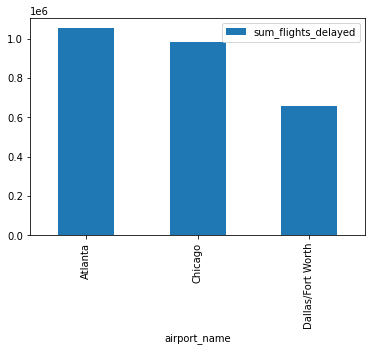

In [25]:
d = df.groupBy("airport_code","airport_name")\
.agg(_sum("flights_delayed").alias("sum_flights_delayed")).sort("sum_flights_delayed", ascending=False).toPandas()
d.head(3).plot.bar(x="airport_name", y="sum_flights_delayed") 

### Top 3 des aéroports avec le moins de retards

<AxesSubplot:xlabel='airport_name'>

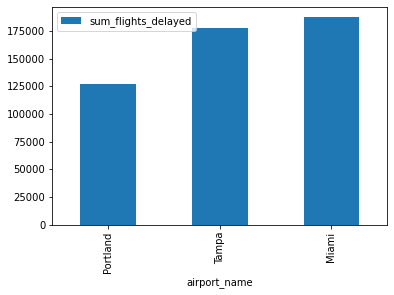

In [26]:
d = df.groupBy("airport_code","airport_name")\
.agg(_sum("flights_delayed").alias("sum_flights_delayed")).sort("sum_flights_delayed", ascending=True).toPandas()
d.head(3).plot.bar(x="airport_name", y="sum_flights_delayed") 

### Somme des retards par mois pour Atlanta en 2004

In [27]:
df.select("time_month","airport_code","airport_name","flights_delayed").filter((df.airport_code == "ATL") & (df.time_year == "2004")).toPandas()

,time_month,airport_code,airport_name,flights_delayed
0,1,ATL,Atlanta,7749
1,2,ATL,Atlanta,11538
2,3,ATL,Atlanta,5408
3,4,ATL,Atlanta,5704
4,5,ATL,Atlanta,8802
5,6,ATL,Atlanta,11719
6,7,ATL,Atlanta,9202
7,8,ATL,Atlanta,7672
8,9,ATL,Atlanta,7430
9,10,ATL,Atlanta,9034


### Diagramme en barre sur le nombre de retard pour Atlanta par mois sur l'année 2004

<AxesSubplot:xlabel='time_month'>

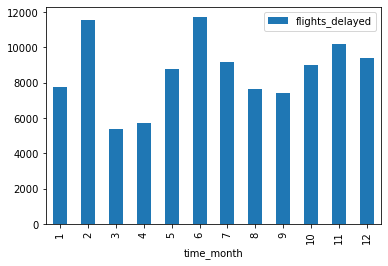

In [28]:
a=df.select("time_month","airport_code","airport_name","flights_delayed").filter((df.airport_code == "ATL") & (df.time_year == "2004")).toPandas()
a.plot.bar(x="time_month", y="flights_delayed")

### Séléction aéroport et affichage des retards par mois

In [29]:
a= df.select("time_year","time_month_name","airport_code","airport_name","flights_delayed")
b= input(print("Quel aéroport voulez-vous voir?"))
b= b.capitalize()
a.filter(df.airport_name == b).toPandas()

Quel aéroport voulez-vous voir?
NoneAtlanta


,time_year,time_month_name,airport_code,airport_name,flights_delayed
0,2003,June,ATL,Atlanta,5843
1,2003,July,ATL,Atlanta,7452
2,2003,August,ATL,Atlanta,7829
3,2003,September,ATL,Atlanta,3936
4,2003,October,ATL,Atlanta,5188
...,...,...,...,...,...
147,2015,September,ATL,Atlanta,3134
148,2015,October,ATL,Atlanta,3098
149,2015,November,ATL,Atlanta,4060
150,2015,December,ATL,Atlanta,5474


### Statistique sur les retards d'un aéroport choisit

In [30]:
b= input(print("Quel aéroport voulez-vous voir?"))
b= b.capitalize()
c= df.filter(df.airport_name == b)

c.groupBy("airport_code", "airport_name","time_month").agg(_sum("flights_delayed").alias("sum_flights_delayed"),
     _mean("flights_delayed").alias("mean_flights_delayed"),
     _min("flights_delayed").alias("min_flights_delayed"),
     max("flights_delayed").alias("max_flights_delayed"))\
    .sort(["airport_code","time_month"], ascending=True).toPandas()
     

Quel aéroport voulez-vous voir?
NoneAtlanta


,airport_code,airport_name,time_month,sum_flights_delayed,mean_flights_delayed,min_flights_delayed,max_flights_delayed
0,ATL,Atlanta,1,82151,6319.307692,3984,8463
1,ATL,Atlanta,2,78777,6564.750000,3509,11538
2,ATL,Atlanta,3,87157,7263.083333,5181,11059
3,ATL,Atlanta,4,69457,5788.083333,3124,8923
4,ATL,Atlanta,5,76047,6337.250000,4446,10324
5,ATL,Atlanta,6,106447,8188.230769,4993,11719
6,ATL,Atlanta,7,116148,8934.461538,4685,13699
7,ATL,Atlanta,8,103384,7952.615385,4944,12861
8,ATL,Atlanta,9,73547,5657.461538,3134,11991
9,ATL,Atlanta,10,86168,6628.307692,3098,13124


## Clusters

In [31]:
c= df.groupBy("airport_code", "airport_name").agg(_mean("flights_delayed").alias("mean_flights_delayed")).sort("airport_name", ascending=True)
                            

In [32]:
vecAssembler = VectorAssembler(inputCols=["mean_flights_delayed"], outputCol="features")
new_df = vecAssembler.transform(c)
new_df.show()

+------------+-----------------+--------------------+--------------------+
|airport_code|     airport_name|mean_flights_delayed|            features|
+------------+-----------------+--------------------+--------------------+
|         ATL|          Atlanta|             6923.75|           [6923.75]|
|         BWI|        Baltimore|  1557.3157894736842|[1557.3157894736842]|
|         BOS|           Boston|  2135.4934210526317|[2135.4934210526317]|
|         CLT|        Charlotte|  1826.4407894736842|[1826.4407894736842]|
|         MDW|          Chicago|   1343.046052631579| [1343.046052631579]|
|         ORD|          Chicago|  6480.0526315789475|[6480.0526315789475]|
|         DFW|Dallas/Fort Worth|   4326.236842105263| [4326.236842105263]|
|         DEN|           Denver|  3330.5131578947367|[3330.5131578947367]|
|         DTW|          Detroit|  2035.7236842105262|[2035.7236842105262]|
|         FLL|  Fort Lauderdale|  1247.2697368421052|[1247.2697368421052]|
|         IAH|          H

In [33]:
kmeans = KMeans(k=3, seed=1)  # 2 clusters here
model = kmeans.fit(new_df.select('features'))

In [34]:
transformed = model.transform(new_df)
transformed.show()

+------------+-----------------+--------------------+--------------------+----------+
|airport_code|     airport_name|mean_flights_delayed|            features|prediction|
+------------+-----------------+--------------------+--------------------+----------+
|         ATL|          Atlanta|             6923.75|           [6923.75]|         1|
|         BWI|        Baltimore|  1557.3157894736842|[1557.3157894736842]|         0|
|         BOS|           Boston|  2135.4934210526317|[2135.4934210526317]|         0|
|         CLT|        Charlotte|  1826.4407894736842|[1826.4407894736842]|         0|
|         MDW|          Chicago|   1343.046052631579| [1343.046052631579]|         0|
|         ORD|          Chicago|  6480.0526315789475|[6480.0526315789475]|         1|
|         DFW|Dallas/Fort Worth|   4326.236842105263| [4326.236842105263]|         2|
|         DEN|           Denver|  3330.5131578947367|[3330.5131578947367]|         2|
|         DTW|          Detroit|  2035.7236842105262|[

In [35]:
c= df.groupBy("airport_code", "airport_name").agg(_mean("flights_cancelled").alias("mean_flights_cancelled")).sort("airport_name", ascending=True)
                 

In [36]:
vecAssembler = VectorAssembler(inputCols=["mean_flights_cancelled"], outputCol="features")
new_df = vecAssembler.transform(c)
new_df.show()

+------------+-----------------+----------------------+--------------------+
|airport_code|     airport_name|mean_flights_cancelled|            features|
+------------+-----------------+----------------------+--------------------+
|         ATL|          Atlanta|     566.9473684210526| [566.9473684210526]|
|         BWI|        Baltimore|    112.65789473684211|[112.65789473684211]|
|         BOS|           Boston|    254.28947368421052|[254.28947368421052]|
|         CLT|        Charlotte|    156.26973684210526|[156.26973684210526]|
|         MDW|          Chicago|     97.40789473684211| [97.40789473684211]|
|         ORD|          Chicago|      950.171052631579|  [950.171052631579]|
|         DFW|Dallas/Fort Worth|     531.5921052631579| [531.5921052631579]|
|         DEN|           Denver|    236.35526315789474|[236.35526315789474]|
|         DTW|          Detroit|     196.6315789473684| [196.6315789473684]|
|         FLL|  Fort Lauderdale|     58.38815789473684| [58.38815789473684]|

In [37]:
kmeans = KMeans(k=3, seed=1)  # 2 clusters here
model = kmeans.fit(new_df.select('features'))

In [38]:
transformed = model.transform(new_df)
transformed.show()

+------------+-----------------+----------------------+--------------------+----------+
|airport_code|     airport_name|mean_flights_cancelled|            features|prediction|
+------------+-----------------+----------------------+--------------------+----------+
|         ATL|          Atlanta|     566.9473684210526| [566.9473684210526]|         2|
|         BWI|        Baltimore|    112.65789473684211|[112.65789473684211]|         0|
|         BOS|           Boston|    254.28947368421052|[254.28947368421052]|         0|
|         CLT|        Charlotte|    156.26973684210526|[156.26973684210526]|         0|
|         MDW|          Chicago|     97.40789473684211| [97.40789473684211]|         0|
|         ORD|          Chicago|      950.171052631579|  [950.171052631579]|         1|
|         DFW|Dallas/Fort Worth|     531.5921052631579| [531.5921052631579]|         2|
|         DEN|           Denver|    236.35526315789474|[236.35526315789474]|         0|
|         DTW|          Detroit|

In [39]:
c= df.groupBy("airport_code", "airport_name")\
    .agg(_mean("flights_cancelled").alias("mean_flights_cancelled"),
         _mean("flights_delayed").alias("mean_flights_delayed")
        ).sort("airport_name", ascending=True)
                 

In [40]:
vecAssembler = VectorAssembler(inputCols=["mean_flights_delayed","mean_flights_cancelled"], outputCol="features")
new_df = vecAssembler.transform(c)
new_df.show()

+------------+-----------------+----------------------+--------------------+--------------------+
|airport_code|     airport_name|mean_flights_cancelled|mean_flights_delayed|            features|
+------------+-----------------+----------------------+--------------------+--------------------+
|         ATL|          Atlanta|     566.9473684210526|             6923.75|[6923.75,566.9473...|
|         BWI|        Baltimore|    112.65789473684211|  1557.3157894736842|[1557.31578947368...|
|         BOS|           Boston|    254.28947368421052|  2135.4934210526317|[2135.49342105263...|
|         CLT|        Charlotte|    156.26973684210526|  1826.4407894736842|[1826.44078947368...|
|         MDW|          Chicago|     97.40789473684211|   1343.046052631579|[1343.04605263157...|
|         ORD|          Chicago|      950.171052631579|  6480.0526315789475|[6480.05263157894...|
|         DFW|Dallas/Fort Worth|     531.5921052631579|   4326.236842105263|[4326.23684210526...|
|         DEN|      

In [41]:
kmeans = KMeans(k=3, seed=1)  # 2 clusters here
model = kmeans.fit(new_df.select('features'))

In [42]:
transformed = model.transform(new_df)
transformed.show()

+------------+-----------------+----------------------+--------------------+--------------------+----------+
|airport_code|     airport_name|mean_flights_cancelled|mean_flights_delayed|            features|prediction|
+------------+-----------------+----------------------+--------------------+--------------------+----------+
|         ATL|          Atlanta|     566.9473684210526|             6923.75|[6923.75,566.9473...|         1|
|         BWI|        Baltimore|    112.65789473684211|  1557.3157894736842|[1557.31578947368...|         0|
|         BOS|           Boston|    254.28947368421052|  2135.4934210526317|[2135.49342105263...|         0|
|         CLT|        Charlotte|    156.26973684210526|  1826.4407894736842|[1826.44078947368...|         0|
|         MDW|          Chicago|     97.40789473684211|   1343.046052631579|[1343.04605263157...|         0|
|         ORD|          Chicago|      950.171052631579|  6480.0526315789475|[6480.05263157894...|         1|
|         DFW|Dalla